In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.signal import savgol_filter
import seaborn as sb
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import os

In [2]:
class datatable:
    def __init__(self,datadict,fastaFile):
        self.reps = datadict['reps'] # list of replicates used 
        self.ntimepts = datadict['ntimepts'] # original number of timepoints in dataset i.e. before subsetting for parameter fitting
        self.X = datadict['X'] # dataset used to fit model parameters
        self.newntimepts = datadict['newntimepts'] # number of timepoints in dataset used to fit model parameters
        self.transcriptIDs = datadict['transcriptIDs'] # all transcriptIDs of original dataset
        self.keepers = datadict['keepers'] # indicies of genes kept for parameter fitting
        self.keep_transcriptIDs = [self.transcriptIDs[i] for i in self.keepers] # transcriptIDs corresponding to used dataset
        self.A = datadict['A'] # learned model
        self.cd = datadict['cd'] # R^2 obtained over n-step prediction
        self.percent_nonzero_to_zero = datadict['percent_nonzero_to_zero'] # percent of nonzero elements that were set to zero during sparsification
        self.C = datadict['C'] # observer matrix
        self.opt_horizon = datadict['opt_horizon'] # horizon for optimization to obtain observer matrix
        self.sparseThresh = datadict['sparseThresh'] # mod of all elements of A less than sparseThresh were set to 0
        self.filter_method = datadict['filter_method'] # the method used for gene downselection 
        self.filterBeforeBS = datadict['filterBeforeBS'] # 'True' if downselection was done before background subtraction
        self.norm = datadict['norm'] # 'True' if the data was normalized
        self.records = list(SeqIO.parse(fastaFile,'fasta')) # full cds_from_genome fasta
        self.keep_records = [] # getting records of genes that we have used
        for tx in self.keep_transcriptIDs:
            for rec in self.records:
                if rec.name == tx:
                    self.keep_records.append(rec)
        self.names,self.genes,self.locus_tags,self.proteins,self.locations = [],[],[],[],[] # get descriptions from keep_records
        c = 0
        for rec in self.keep_records:
            self.names.append(rec.name)
            rec_elems = [x.strip().strip(']') for x in rec.description.split(' [')]
            if (len(rec_elems)==7) or (len(rec_elems)==8): # sequence has protein description without any brackets in it
                if 'gene=' in str(rec_elems): # sequence has gene name
                    self.genes.append(rec_elems[1][5:])   
                    self.locus_tags.append(rec_elems[2][10:])
                    self.proteins.append(rec_elems[4][8:])
                    self.locations.append(rec_elems[6][9:])
                elif 'gene=' not in str(rec_elems): # sequence has no gene name
                    self.genes.append('N/A')
                    self.locus_tags.append(rec_elems[1][10:])
                    self.proteins.append(rec_elems[3][8:])
                    self.locations.append(rec_elems[5][9:])
            else:  # sequence has protein description with brackets at boundary of string e.g. [ATP] at end of description (the splitting above splits the protein field up into a few different fields.)
                if 'gene=' in str(rec_elems): # there are two sub cases, with or without gene name
                    self.genes.append(rec_elems[1][5:])   
                    self.locus_tags.append(rec_elems[2][10:])
                    self.proteins.append('MANUAL_LOOKUP')
                    self.locations.append('MANUAL_LOOKUP')
                elif 'gene=' not in str(rec_elems):
                    self.genes.append('N/A')
                    self.locus_tags.append(rec_elems[1][10:])
                    self.proteins.append('MANUAL_LOOKUP')
                    self.locations.append('MANUAL_LOOKUP')
        # sort C in ascending order and get corresponding inds
        self.sorted_inds = self.C[:,0].argsort() # getting indices of C in ascending order
        self.sorted_C = self.C[self.sorted_inds] # sort C in ascnding order
        self.sorted_transcriptIDs = [self.keep_transcriptIDs[i] for i in self.sorted_inds]
        self.sorted_names = [self.names[i] for i in self.sorted_inds]
        self.sorted_genes = [self.genes[i] for i in self.sorted_inds]
        self.sorted_locus_tags = [self.locus_tags[i] for i in self.sorted_inds]
        self.sorted_proteins = [self.proteins[i] for i in self.sorted_inds]
        self.sorted_locations = [self.locations[i] for i in self.sorted_inds]

In [3]:
def plot_bs_gene_traces(data,genes,tags,reps=[0,1,2],savedir='figures/',savefig=False,showfig=False):
    '''data is of shape n x m x r where n is #genes, m is #tps, r is # replicates.
        Make sure n is a multiple of 10. genes is a list with the gene names and tags is a list of locus_tags '''
    tspan = np.linspace(20,100,data.shape[1])
    nreps = len(reps)
    data = data[:,:,reps]
    ncols = 10
    nrows = int(data.shape[0]/ncols) 
    fig, axs = plt.subplots(nrows, ncols, figsize=(22,17));
    mt =  ['o--','d--','p--']
    repname = ['R1','R2','R3']
    colors = ['tab:blue','tab:orange','tab:green']
    count = 0
    for ax in axs.reshape(-1):
        ymin,ymax = np.min(data[count])-25,np.max(data[count])+25
        for rr in range(0,nreps):
            ax.plot(tspan,data[count,:,rr],mt[rr],lw=2,ms=5,color=colors[rr],label=repname[rr]);
            # add gene names or locus tags to subplot title
            if genes[count] == 'N/A':
                ax.set_title(tags[count],fontsize=12)
            else:
                ax.set_title(genes[count],fontsize=12)
        # Hide the right and top spines and make bottom and left axes thicker
        for axis in ['right','top']:
            ax.spines[axis].set_visible(False)
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(1.2)
        # increase ticklabel fontsizes
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_ylim([ymin,ymax])
        count+=1
        
    axs[-1,-1].legend(repname,bbox_to_anchor=(1.05, 1),loc='upper left',markerscale=2,fontsize=12,shadow=True)
    
    # Set common labels
    fig.text(0.5, -0.01, r'$Time \; (minutes)$', ha='center', va='center',fontsize=25)
    fig.text(-0.04, 0.5, r'$TPM_{BS}$', ha='center', va='center', rotation='vertical',fontsize=25)
        
    plt.tight_layout();
    if savefig:
        plt.savefig(savedir)
    if not showfig:
        plt.close()

In [4]:
data_dir = 'data/'
results_dir = 'run-outputs/'
cdsFasta = data_dir+'GCA_000009225.1_ASM922v1_cds_from_genomic.fa'
data0 = datatable(pickle.load(open(results_dir+'dump012_filterB4BS_DTW_IC0_m8.pickle','rb')),cdsFasta)
data1 = datatable(pickle.load(open(results_dir+'dump012_filterAfterBS_DTW_IC0_m8.pickle','rb')),cdsFasta)

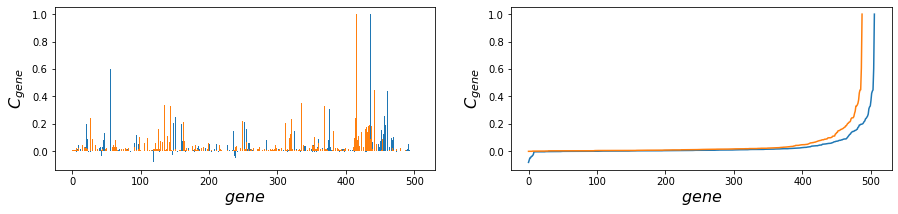

In [5]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,3));
ax[0].bar(np.arange(0,len(data0.C)),data0.C[:,0])
ax[0].bar(np.arange(0,len(data1.C)),data1.C[:,0])
ax[0].set_ylabel(r'$C_{gene}$',fontsize=16);
ax[0].set_xlabel(r'$gene$',fontsize=16);
ax[1].plot(data0.sorted_C);
ax[1].plot(data1.sorted_C);
ax[1].set_ylabel(r'$C_{gene}$',fontsize=16);
ax[1].set_xlabel(r'$gene$',fontsize=16);

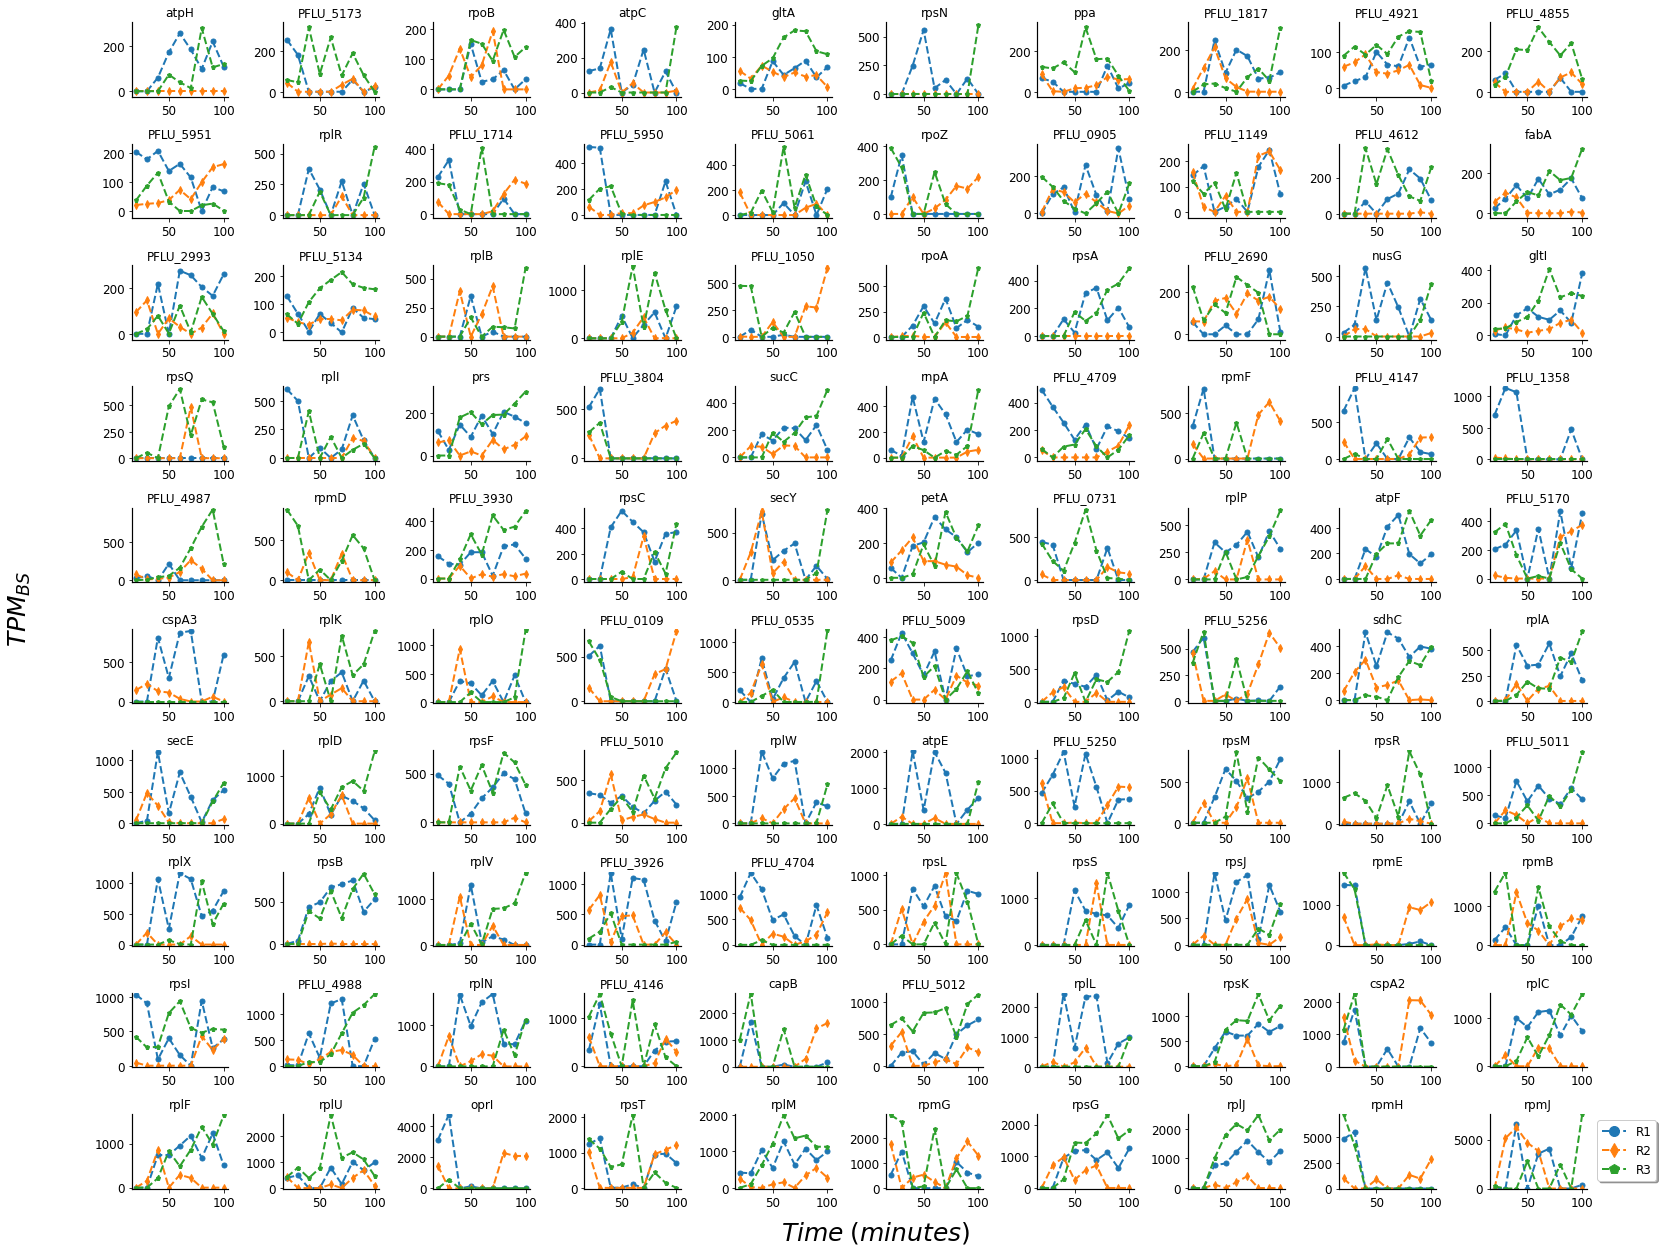

In [6]:
k = 100
save_dir = 'figures/test.pdf'
plot_bs_gene_traces(data0.X[data0.sorted_inds[-k:]],data0.sorted_genes[-k:],data0.sorted_locus_tags[-k:],\
                    reps=data0.reps,savedir=save_dir,savefig=False,showfig=True)

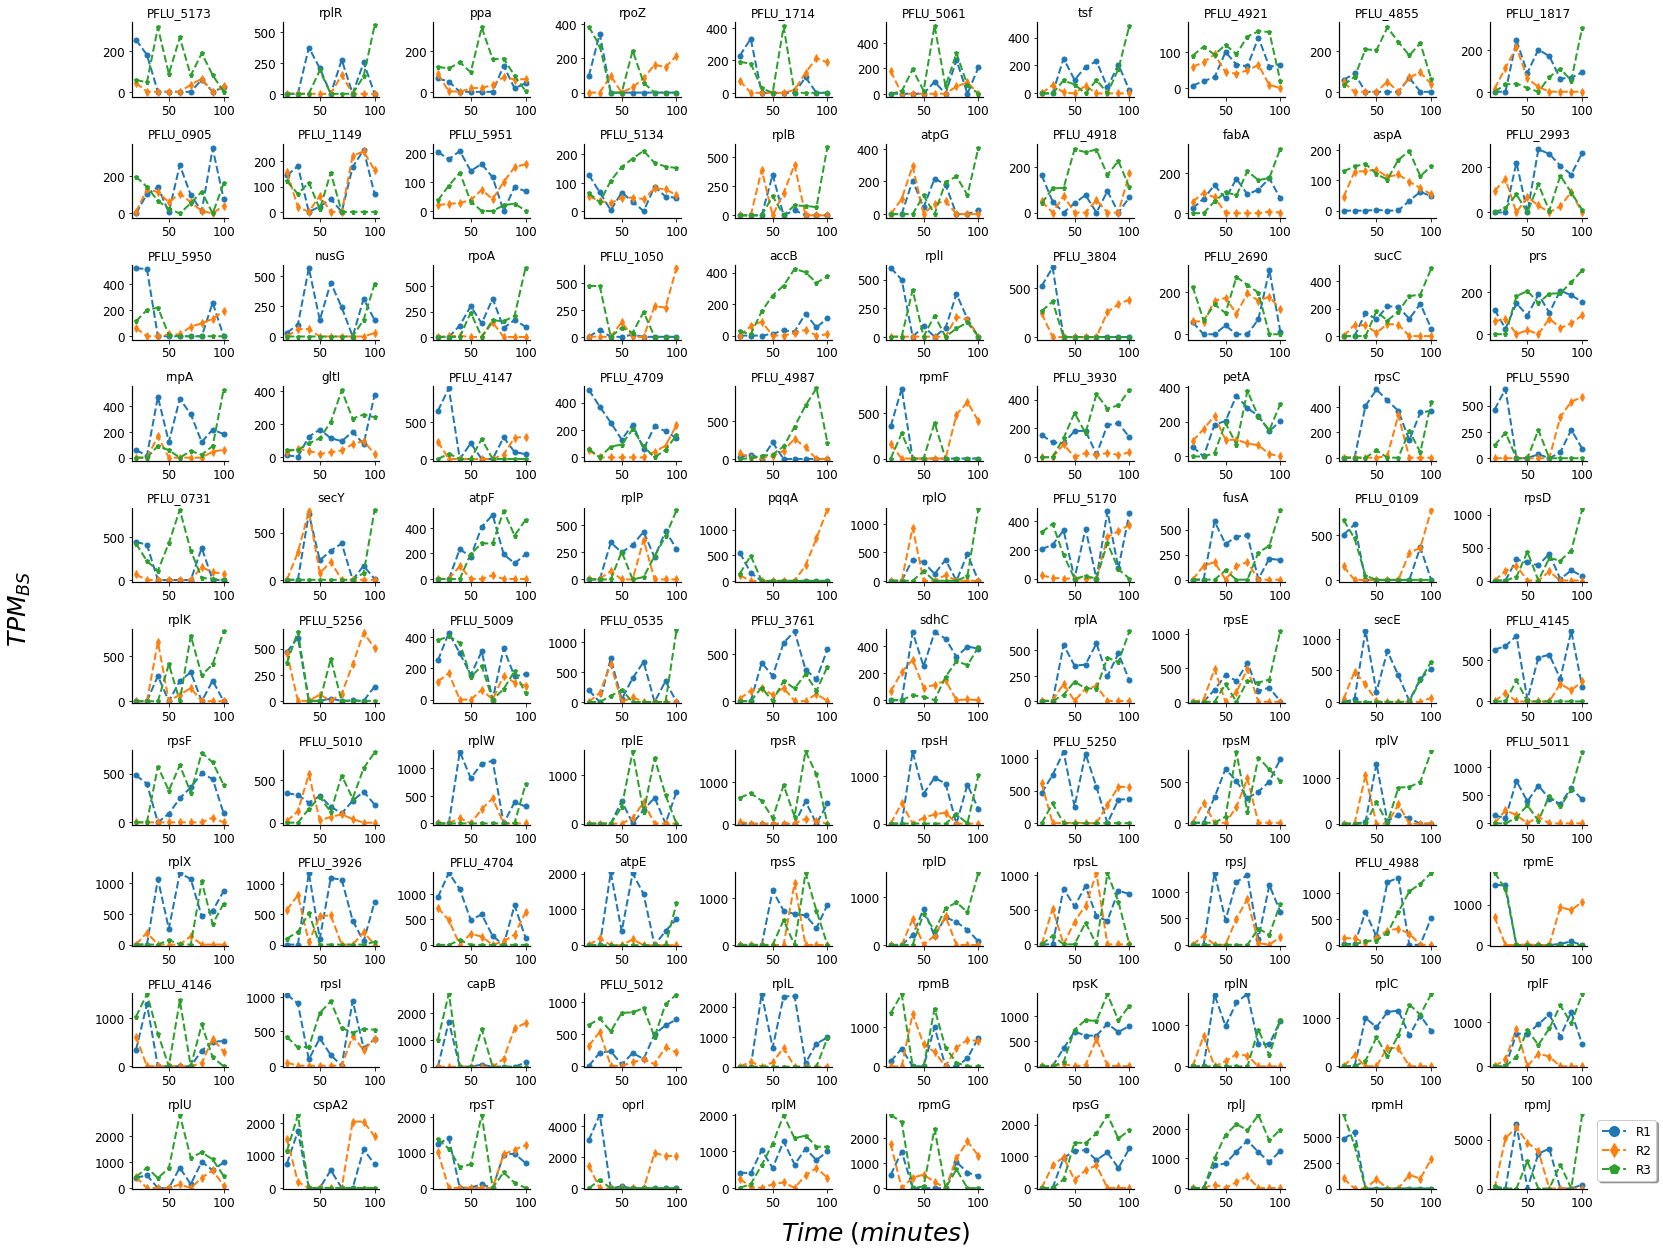

In [7]:
k = 100
save_dir = 'figures/test'
plot_bs_gene_traces(data1.X[data1.sorted_inds[-k:]],data1.sorted_genes[-k:],data1.sorted_locus_tags[-k:],\
                    reps=data1.reps,savedir=save_dir,savefig=False,showfig=True)

#### Get the intergenic regions (or putative promoter regions) from the genbank (gbff) file

In [45]:
# Copyright(C) 2009 Iddo Friedberg & Ian MC Fleming
# Released under Biopython license. http://www.biopython.org/DIST/LICENSE
# Do not remove this comment
def get_interregions(genbank_path,intergene_length=1):

    seq_record = next(SeqIO.parse(open(genbank_path), 'genbank'))
    cds_list_plus = []
    cds_list_minus = []
    # Loop over the genome file, get the CDS features on each of the strands
    for feature in seq_record.features:
        if feature.type == "CDS":
            mystart = feature.location.start.position
            myend = feature.location.end.position
            if feature.strand == -1:
                cds_list_minus.append((mystart, myend, -1))
            elif feature.strand == 1:
                cds_list_plus.append((mystart, myend, 1))
            else:
                sys.stderr.write("No strand indicated %d-%d. Assuming +\n" % (mystart, myend))
                cds_list_plus.append((mystart, myend, 1))
    intergenic_records = []
    for i, pospair in enumerate(cds_list_plus[1:]):
        # Compare current start position to previous end position
        last_end = cds_list_plus[i][1]
        this_start = pospair[0]
        strand = pospair[2]
        if this_start - last_end >= intergene_length:
            intergene_seq = seq_record.seq[last_end:this_start]
            strand_string = "+"
            # store the intergenic region in the description field
            intergenic_records.append(SeqRecord(intergene_seq,id="%s-ign-%d %s"%(seq_record.name,i,strand_string),\
                        description="%d-%d"%(last_end+1,this_start),))
    for i, pospair in enumerate(cds_list_minus[1:]):
        # Compare current start position to previous end position
        last_end = cds_list_minus[i][1]
        this_start = pospair[0]
        strand = pospair[2]
        if this_start - last_end >= intergene_length:
            intergene_seq = seq_record.seq[last_end:this_start]
            strand_string = "-"
            intergenic_records.append(SeqRecord(intergene_seq,id="%s-ign-%d %s"%(seq_record.name,i,strand_string),\
                        description="%d-%d"%(last_end+1,this_start),))
    return intergenic_records

In [46]:
genbank_path = 'data/GCA_000009225.1_ASM922v1_genomic.gbff'
intergenic_records = get_interregions(genbank_path,intergene_length=1)
outpath = os.path.splitext(os.path.basename(genbank_path))[0] + "_ign.fa"
SeqIO.write(intergenic_records, open('data/'+outpath, 'w'), 'fasta');